


# How To Use XModalix
X-Modalix is our implementation of a cross modal autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extenisve, because
our pipeline works similar for different architecture, so here we focus only on `X-Modalix` specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Stackix pipeline. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.


## XModalix Theory
The core idead of cross modal autoencoder to align the latent spaces of different data modalities. After fitting such aligned latent distributions, we can translate between different data modalities by feeding data from one modality to its corresponding encoder and then feeding the latent space to the decoder of the target (the modality you want to translate to) modality.

The underlying models are separate VAE's; one for each data modality which are trained in parallel. However, their latent spaces are very closely aligned in a way that data modalities can hardly be discriminated, but sample variation is kept.  
To get an aligned latent space, the loss function to train the VAE's is extended by the following terms and ideas:

- *Adversarial* loss term: in parallel to the VAEs a third neural network (latent space classifier) is trained to discriminate the latent space embeddings of the different data modalities. Analogously to a GAN, the inverse loss of this latent space classifier is used as loss term in addition to the normal VAE loss function to enforce an alignment of latent spaces. <br> <br>
- *Paired* loss term: Latent space alignment is further enforced by minimizing the distance between samples with paired measurements of each data modality. In our current implementation, we allow also unpaired samples, to get sensible results, we recomment the majority of samples to be paired (present in all data modalities). <br> <br>
- *Class-based* loss term: This is a semi-supervised training loss term can be used, which minimizes distance among each class of samples. A class memebership of a sample is defined in the annotation data and can be something like a cancer type, or cell type, etc. In each iteration we calculate a class mean of all samples of a class in the latent space.  Subsequently we calculate the distance between a sample of this class and the class mean. See our `Preprint [TODO]` for more details. <br> <br>


---
## What You'll Learn

As a showcase for data modality translation by `x-modalix`, we will use cancer gene expression from TCGA as in combination with handwritten digits from the [MNIST data set](https://keras.io/api/datasets/mnist/).  
Our goal is to translate the gene expression signature of five selected cancer subtypes to images of digits, where each cancer subtype class is assigned to a digit between 0-4:  

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/729f3e8172a722e7c3681298719d9d4b59e313d9/images/xmodalix_scheme.svg" alt="ontix-ontologies" width="1200"/>
In practice those images can be histopathological images or any other data modality. Before we show data preparation and `x-modalix` training, some background to the basic idea of a cross-modal VAE as proposed by [Yang & Uhler](https://arxiv.org/abs/1902.03515). 


While following the showcase you learn how to:

1. **Initialize** pipeline and run the pipeline. <br> <br>
2. Understand the X-Modalix sepecific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access the X-Modalix specific **results** (sub-results for modality autoencoders). <br><br>
4. **Visualize** and **Evaluate** the outputs. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 



## 1) Initialize and Run XModalix
In this case we read our input data from files. We define the file locations in our config. This is done via a part of the config object, called DataConfig (see details Python code below).  
We go over a few custom config parameters for `XModalix`. For a deep dive into the config object see [1]
- `pretrain_epochs`: Before training the whole `X-Modalix`, we can pretrain the sub VAEs of each modality. This param can be set globally for all data modalities or individually per data modality. It specifies the number of epochs of the pretraining. 
- `gamma`: Hyperparameter to weight adversarial loss term.
- `delta_pair`: Hyperparameter to weight paired loss term.
- `delta_class`: Hyperparameter to weight class loss term.

### Extra 1: Getting Tutorial Data
You can run these bash commands to get the data and have the correct path **We assume you're in the root of autoencodix_package**
```bash
mkdir -p data
cd data
wget "https://cloud.scadsai.uni-leipzig.de/index.php/s/bq64MaQyZGZfN64/download/XModalix-Tut-data.zip"
unzip  XModalix-Tut-data.zip -d XModalix-Tut-data
```

### Extra 2: Get correct path
We assume to be in root of our package, the following code makes sure we are.
[1] Tutorials/DeepDives/ConfigTutorial.ipynb

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


### Extra 3: Data Assumptions
Since X-Modalix allows for two special cases ((a) we allow image data and (b) we allow unpaired data), we have some requirements for the input data. In our config object, we need to fill the `DataConfig` with certain info. Let's first look at the code and then explain each requirements step-by-step:
```python
imganno_file = os.path.join("data/XModalix-Tut-data/tcga_mappings.txt")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")
clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")

dc = DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=3,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        })
```

For image data, we need to specify the root folder where the images are located. Our preprocessor will than read all images and parse them to tensors. We allow the following extensions: .jpg", ".jpeg", ".png", ".tif", ".tiff" (NOT case sensitve).  
Next there needs to be some kind of mapping between the image name (filepath without directories) and a sample_id and ideally with other metadata.
For this you have two ways: Either you provide a global annotation file that contains all sample_ids and columns with metadata, including one column with the image path. You can define the name of the column with the config parameter `img_path_col` default is "img_paths". See your `clin_file` as example below.  

Furthermore, we need to specify the `translate_direction`. We train a shared latent alignment, so the translation between all modalities is possible, but to keep the results neat, we expect users to define a direction. If you later want to change the direction or have another pair, you can specify this in predict step as shown in [Section 3](#3-access-xmodalix-results).

In [2]:
import os
import pandas as pd
import autoencodix as acx

from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase

clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")
clin_df = pd.read_parquet(clin_file)
print("First five image paths:")
print(clin_df["img_paths"].to_list()[0:5])
print("\n")
clin_df.head()


First five image paths:
['2331_label_0.png', '2332_label_0.png', '2333_label_0.png', '2334_label_0.png', '2335_label_0.png']




,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,ANEUPLOIDY_SCORE,...,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL,img_paths
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,unknown,No,Yes,3C,Breast,19.0,...,0:LIVING,133.050597,0:ALIVE OR DEAD TUMOR FREE,133.050597,1:Recurred/Progressed,59.440444,1:PROGRESSION,59.440444,EUR,2331_label_0.png
TCGA-3C-AALI-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,22.0,...,0:LIVING,131.669790,0:ALIVE OR DEAD TUMOR FREE,131.669790,0:DiseaseFree,131.669790,0:CENSORED,131.669790,AFR,2332_label_0.png
TCGA-3C-AALJ-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,13.0,...,0:LIVING,48.459743,0:ALIVE OR DEAD TUMOR FREE,48.459743,0:DiseaseFree,48.459743,0:CENSORED,48.459743,AFR_ADMIX,2333_label_0.png
TCGA-3C-AALK-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,unknown,No,Yes,3C,Breast,4.0,...,0:LIVING,47.604958,0:ALIVE OR DEAD TUMOR FREE,47.604958,unknown,NaN,0:CENSORED,47.604958,AFR,2334_label_0.png
TCGA-4H-AAAK-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,unknown,Yes,No,4H,Breast,7.0,...,0:LIVING,11.440971,0:ALIVE OR DEAD TUMOR FREE,11.440971,0:DiseaseFree,11.440971,0:CENSORED,11.440971,EUR,2335_label_0.png


Another way is to provide a image-specific annotation file in with the `extra_anno_file` parameter of the DataInfo object in the DataConfig.
Here you need to map the sample_id (index) to the image path and can add addtional metadata columns like we did in our `imganno_file`.   
> We recommend the first option of a global annotation file.


In [3]:
imganno_file = os.path.join("data/XModalix-Tut-data/tcga_mappings.txt")
img_anno_df = pd.read_csv(imganno_file, sep="\t", index_col=0)
img_anno_df.head()

,img_paths,extra_class_labels,CANCER_TYPE_ACRONYM
sample_ids,,,
TCGA-05-4244-01,0_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4249-01,1_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4250-01,2_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4382-01,3_label_1.png,Non-Small Cell Lung Cancer,LUAD
TCGA-05-4384-01,4_label_1.png,Non-Small Cell Lung Cancer,LUAD


## 1) Initialize and Run XModalix
We show how to set up the config to account for the data requirements and also highlight the custom XModalix paramters.
For a more in depth guide on the config parameters and/or the input data see [1] and [2].


[1] `Tutorials/DeepDives/ConfigTutorial.ipynb`  
[2] `Tutorials/DeepDives/InputDataTutorials.ipynb`

In [4]:
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")

xmodalix_config = XModalixConfig(
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=60,
    beta=0.01,
    gamma=2,
    delta_class=0.0,
    delta_pair=3.0,
    latent_dim=8,
    requires_paired=False,
    pretrain_epochs=15,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=50,
                # extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)
result = xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 64x64
Successfully loaded 3230 images for img
anno key: rna
anno key: img
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  rna: 3552 samples × 55 features
  img: 3230 samples × 55 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  rna: 3552 samples × 55 features
  img: 3230 samples × 55 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  rna: 3552 samples × 55 features
  img: 3230 samples × 55 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
Converting 2261 images t

## 2) XModalix Specific Steps

XModalix does not introduce additional steps to the overall pipeline. However, its preprocessing and training differs slightly from Varix and Vanillix. XModalix processes each data modality individually and thus supports unpaired data input.   
However, it is possilbe to re-run the predict step and change the translation pairs or the translation direction by provding `from_key` and `to_key` argument with the string key that defined your data modality ("rna" and "img" in our case), see code below for details.

Furthermore, the visualization and evaluation step produce different some different outputs than the other pipelines, but we'll focus on this in [section 4](#4-visualize-and-evaluate-xmodalix)



In [5]:
# initially, we translated from rna to image, now we can use the trained model to re-run translation with switched pairs
# ATTENTION: This overwrite the result object, so we need to
from copy import deepcopy

backup_result = deepcopy(result)
result_flipped = xmodalix.predict(from_key="img", to_key="rna")

Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.rna'
  - Added 20 source feature IDs to .uns
Finished processing latent results.


## 3) Access XModalix Results
Accessing the results also works slightly different for `XModalix`, because we have:
- multiple latentspaces (one for each data modality). <br><br>
- not just reconstructions, but also `translations` and `reference translation` (this are reconstructions within one data modality on the same split as the translation, so if we translate from `rna` to `img`, this would be the reconstruction from `img` to `img`). We can access these `translation` via the `reconstruction` attribute of the result object, where we first apply the usual `TrainingDynamics` API via get() and then have a dict for each data modality and translaiton and reference translation <br> <br>
- multiple losses. These are accessed via the  `sub_losses` attribute of the `result` object. This is a Dict of TrainingDynamics. So first you need to select the loss type you're interested and then you can work with the usual `TrainingDyanmics` API. <br><br>

See the code below for more details and [3] for even more details:  

[3] `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`



In [6]:
print("Find available loss types")
print(backup_result.sub_losses.keys())
print("Get adver_loss for training")
backup_result.sub_losses.get("adver_loss").get(split="train")

Find available loss types
dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.rna.recon_loss', 'multi_bulk.rna.var_loss', 'multi_bulk.rna.anneal_factor', 'multi_bulk.rna.effective_beta_factor', 'multi_bulk.rna.loss', 'img.img.recon_loss', 'img.img.var_loss', 'img.img.anneal_factor', 'img.img.effective_beta_factor', 'img.img.loss', 'clf_loss'])
Get adver_loss for training


array([ 6.51828441, 12.2915692 , 14.98758877, 15.9462902 , 17.43315373,
       17.20132611, 17.94412926, 18.27766799, 18.27116325, 19.563247  ,
       19.67452244, 21.01674355, 18.83315276, 20.68479221, 19.68828144,
       19.60308776, 20.34447552, 20.4825607 , 20.86368629, 20.66125376,
       19.81650694, 20.98037567, 19.18532986, 19.95523173, 19.62515674,
       20.85974376, 19.90559789, 21.67486761, 21.04103943, 21.34952456,
       22.28973107, 23.1975513 , 22.28494438, 22.05244206, 23.12125101,
       22.39712466, 23.76810755, 22.76881537, 24.42053393, 22.9155977 ,
       23.01177369, 20.48521275, 20.8849592 , 21.73026937, 21.8812762 ,
       22.54886723, 22.28627317, 21.66328311, 20.81732475, 21.13964222,
       21.57368493, 20.05576524, 21.01436218, 20.99955353, 22.78477065,
       23.15699466, 25.31352905, 25.24342917, 25.66027772, 25.40989234])

In [7]:
print("Get reconstruction keys")
# Frist define split and epoch you're interested in
# usually test split (there are no epochs, so by default this is always epoch=-1)
recons = backup_result.reconstructions.get(split="test", epoch=-1)
print(recons.keys())
print("Getting Translation")
trans = recons.get("translation")
print(f"shape of translation: {trans.shape}")

Get reconstruction keys
dict_keys(['multi_bulk.rna', 'img.img', 'translation', 'reference_img.img_to_img.img'])
Getting Translation
shape of translation: (711, 1, 64, 64)


**We can acutally plot a sample image here**

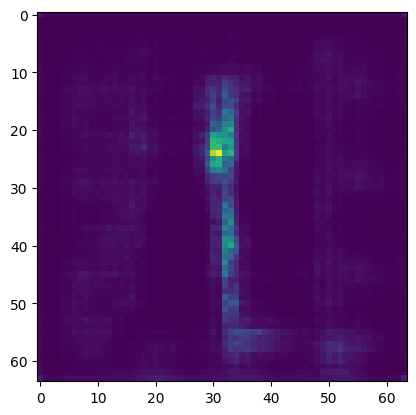

In [8]:
import matplotlib.pyplot as plt

sample = trans[0, 0, :, :]
plt.imshow(sample)
plt.show()

Accessing the latentspaces works analog.

## 4) Visualize and Evaluate XModalix
XModalix offers a few addtional visulizations, namely:
- img grid (TODO) <br><br>
- shared latent (TODO)<br><br>
Additionally, the `evaluate` step works differently for `XModalix`. While for other pipelines, we evaluate the embedding quality with downstream machine learning tasks, here we're interested in how well the biological information is kept in the translated data modality.


Creating plots ...


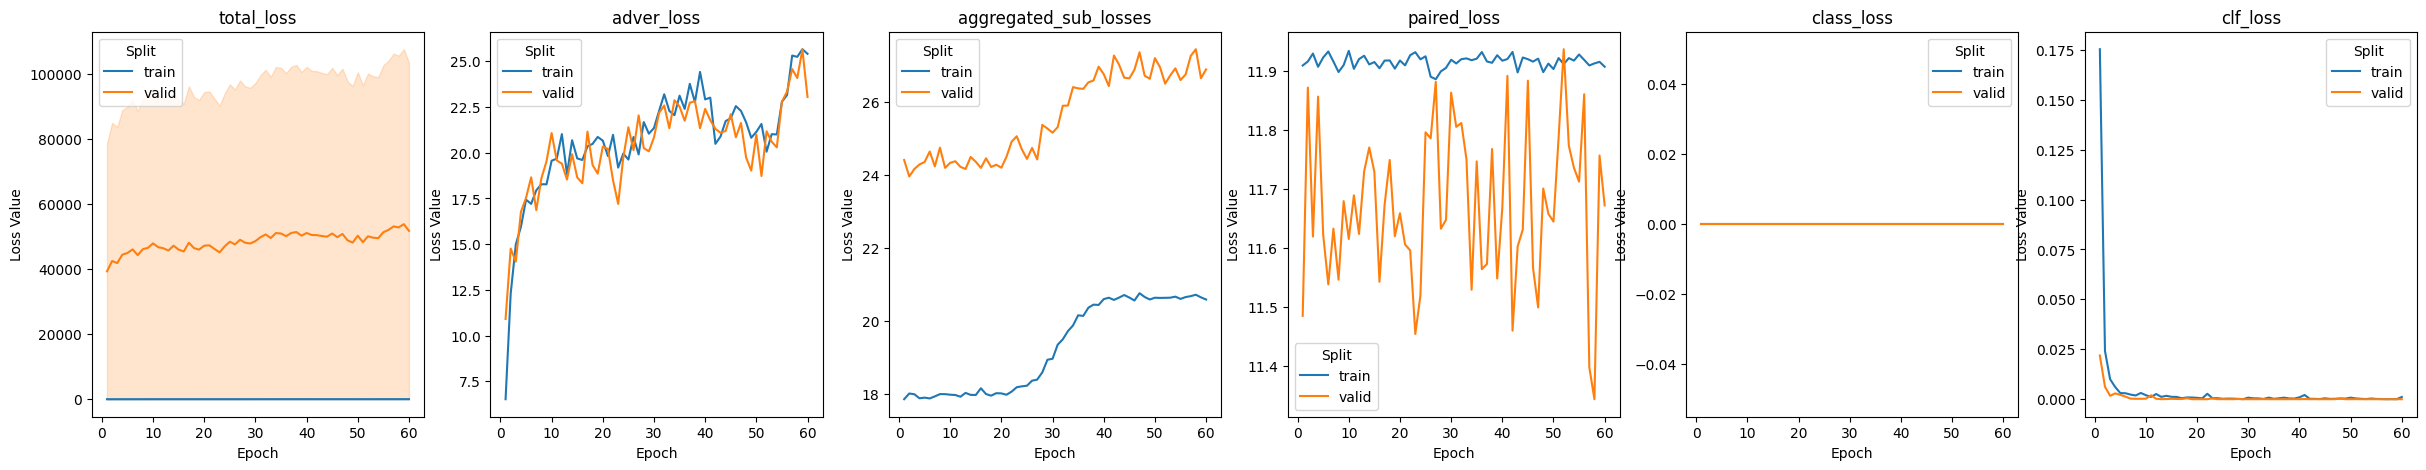

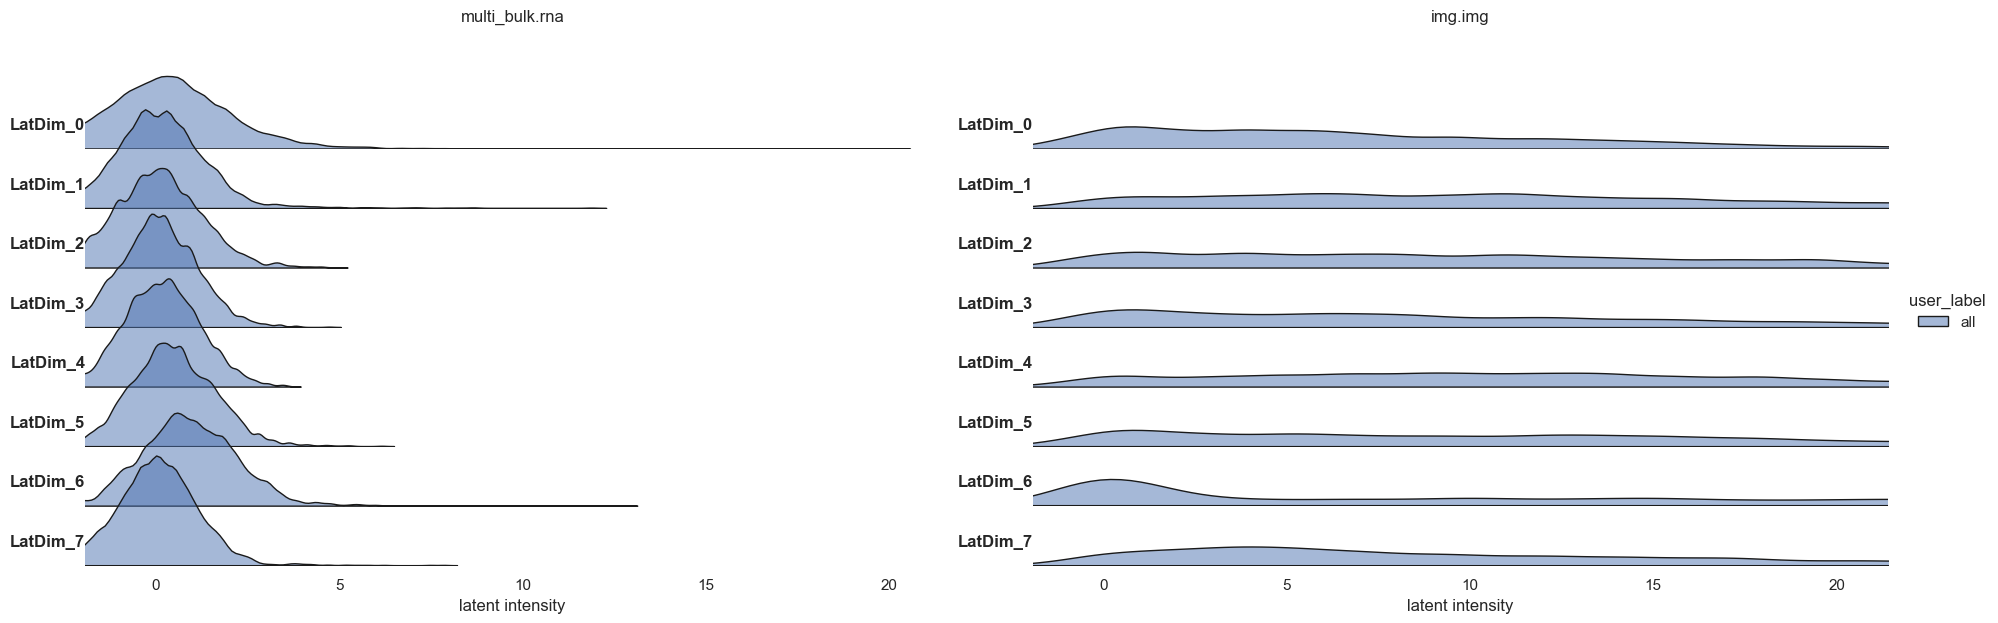

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


KeyError: 'sample_ids'

In [9]:
xmodalix.show_result()

## 5) Apply Custom Parameters

## 6) Save, Load and Reuse XModalix

This works for `XModalix` as for any other models, by using the `save` and `load` methods.

In [ ]:
import os
import glob

outpath = os.path.join("tutorial_res", "xmodalix.pkl")
xmodalix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
xmodalix_loaded = acx.XModalix.load("xmodalix.pkl")
# now you can use the model to predict with a different pair again:

r = xmodalix_loaded.predict(from_key="rna", to_key="rna")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.
PKL files: ['tutorial_res/xmodalix.pkl', 'tutorial_res/xmodalix.pkl_preprocessor.pkl']
Model files: ['tutorial_res/xmodalix.pkl_model.pth']
Attempting to load a pipeline from xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Model state loaded successfully.


ValueError: Invalid translation keys: rna => rna, valid keys are: ['RNA', 'RNA2', 'IMG']